Here we type the variable names/ other notice:
lets start from 10/27

- df: original dataframe saving data from r/Headspace, you can rename it as df_hs if we need data about other mental health platforms

# Part 1: Data Retrieval

In [ ]:
pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 8.3 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
reddit_key = userdata.get('Reddit')
password = userdata.get('password')

In [ ]:
import asyncpraw

reddit = asyncpraw.Reddit(
    client_id="F4r2L7v7VF_zJH7gBA4NAg", # You may edit this to use your own client ID
    client_secret = reddit_key,
    username="MulberryMysterious44", # This is not necessary if you are accessing public data
    password= password, # This is not necessary if you are accessing public data
    user_agent="python:com/prefs/apps:v1.2.2 (by /u/MulberryMysterious44)",# You may edit this to use your own Rrddit ID. Format: script:<your app name>:v1.0 (by /u/<your Reddit ID>)
)

In [ ]:
print(reddit.read_only)

False


In [ ]:
import pandas as pd
import datetime
from datetime import datetime

In [ ]:
async def get_reddit_data(sub, query=False, key_word=None):
    '''
    Retrieve data from a certain subreddit

    attr sub: a string, the subreddit you are interested in
    attr query: a string, sending query for search
    attr key_word: a string, we need to filter data with it
    return: a dataframe
    '''

    subreddit = await reddit.subreddit(sub, fetch=True)

    utc = []
    title = []
    text = []
    comment_body = []
    reply = []
    r_subreddit = []
    url = []

    # Access title, text, date and comments
    async def list_update(submission):
        '''
        Update the list, no return
        '''
        title.append(submission.title)
        text.append(submission.selftext)
        utc.append(submission.created_utc)
        r_subreddit.append(submission.subreddit.display_name)
        url.append(submission.url)
        await submission.comments()
        cm = []
        cm2 = []  # We add top-level replies to comments
        for top_level_comment in submission.comments:
            cm.append(top_level_comment.body)
            if len(top_level_comment.replies) > 0:
                for second_level_comment in top_level_comment.replies:
                    cm2.append(second_level_comment.body)
        comment_body.append(cm)
        reply.append(cm2)

    # Access title, text, date and comments
    if not query:
        async for submission in subreddit.new(limit=1000):
            await submission.load()
            await list_update(submission)
    else:
        async for submission in subreddit.search(query, limit=1000, sort="new"):
            if any(
                keyword in submission.title or
                keyword in submission.selftext
                for keyword in key_word
            ):
                await submission.load()
                await list_update(submission)

    # Convert data into format of a dataframe
    df = pd.DataFrame({
        'date_unformatted': utc,
        'title': title,
        'text': text,
        'comments': comment_body,
        'replies to comments': reply,
        'subreddit': r_subreddit,
        'url': url
    })

    return df

In [ ]:
# Retrive Reddit data from r/HeadspaceApp
df_HeadspaceApp = await get_reddit_data('HeadspaceApp')
# Retrive Reddit data from r/Headspace
df_Headspace = await get_reddit_data('Headspace')
# Retrive Reddit data from r/Meditation with title contains Headspace or HeadSpace
df_Meditation = await get_reddit_data('Meditation', query='title:Headspace', key_word=['Headspace','HeadSpace'])

<ipython-input-6-e8da9d9fc97f>:46: DeprecationWarning: `Submission.comments` is now a property and no longer needs to be awaited. This will raise an error in a future version of Async PRAW.
  await list_update(submission)


TooManyRequests: received 429 HTTP response

In [ ]:
# Connect 3 dataframes
df = pd.concat([df_HeadspaceApp, df_Headspace, df_Meditation], ignore_index=True)

# Sort date descendingly
df = df.sort_values('date_unformatted', ascending=False).reset_index(drop=True)

# Transform data format
def convert_to_date(timestamp):
    return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')
df['date_unformatted'] = df['date_unformatted'].apply(convert_to_date)
df = df.rename(columns={'date_unformatted': 'date'})
df.head()

# Part 2: Tokenization and Simplification

In [ ]:
# found out encoding of the file is MacRoman
!pip install chardet
import chardet

with open("/content/gdrive/MyDrive/headspace_submissions_v2.csv", 'rb') as f:
    result = chardet.detect(f.read())
print(result['encoding'])

MacRoman


In [ ]:
# Import data from my google drive, you can comment this out
# This is data before 2024-11-20
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv("/content/gdrive/MyDrive/headspace_submissions_v2.csv",encoding='MacRoman')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Retain only the first 7 columns
df = df.iloc[:, :7]
df.head(10)

,date,title,text,comments,replies to comments,subreddit,url
0,11/22/2024,What's the longest run streak ever?,I'm curious about what the longest run streak ...,['I was somewhere up into the 1700\'s before I...,[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...
1,11/20/2024,Quality is lacking,I tried the new meditation about finding post ...,['The app was better when it was just Andy. I ...,"['What happened to Andy?', 'I signed up again ...",Headspace,https://www.reddit.com/r/Headspace/comments/1g...
2,11/18/2024,Possible bug in app?,When I connect my Bluetooth headphones to my p...,"[""That is a bug in your phone or Bluetooth dev...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...
3,11/18/2024,Headspace Issue - Has there been any statement...,Just installed Headspace. I want to restart my...,"['I am facing the same issue.', 'Have you trie...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...
4,11/13/2024,VR in Headspace or similar?,Hey Headspace community! üëã\n\nI‚Äôm gatheri...,[],[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...
5,11/12/2024,Playlist option?,Am I able to queue up multiple sleepcasts as t...,particularly night train,slow train,rainday antiques 1&2,holiday chalet and the ones about rocks and c...
6,Are there bits in any of the sleepcasts that y...,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"Are there any other examples?""",['Hahaha. I haven‚Äôt noticed. \n\nHonestly fo...,['I usually start over until I find a breathin...,Headspace,https://www.reddit.com/r/Headspace/comments/1g...,NaN,NaN
9,11/12/2024,Pro tip regarding focusing on breath,I posted a question about difficulty on focusi...,"[""That's awesome! During meditation we tend to...",['As i said the principle remains the same. Ri...,Headspace,https://www.reddit.com/r/Headspace/comments/1g...


In [ ]:
# combine title, text and comments column as the main source
df['combined'] = df.apply(
    lambda row: f"{row['title']} {row['text']} {' '.join(row['comments']) if isinstance(row['comments'], list) else row['comments'] or ''}",
    axis=1
)
df['combined'].head()

,combined
0,What's the longest run streak ever? I'm curiou...
1,Quality is lacking I tried the new meditation ...
2,Possible bug in app? When I connect my Bluetoo...
3,Headspace Issue - Has there been any statement...
4,VR in Headspace or similar? Hey Headspace comm...


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
# remove the urls in the title_text_comment columns and tokenize
df['combined_nonurl'] = df['combined'].apply(lambda text: [token.text for token in nlp(text) if not token.like_url])
df['combined_nonurl'].head()

,combined_nonurl
0,"[What, 's, the, longest, run, streak, ever, ?,..."
1,"[Quality, is, lacking, I, tried, the, new, med..."
2,"[Possible, bug, in, app, ?, When, I, connect, ..."
3,"[Headspace, Issue, -, Has, there, been, any, s..."
4,"[VR, in, Headspace, or, similar, ?, Hey, Heads..."


In [ ]:
# further cleaning, remove characters, numbers, and short words, lowercase
import re
df['tokens'] = df['combined_nonurl'].apply(lambda x: [re.sub(r'[^\w\s]', '', i).lower() for i in x])
df['tokens'] = df['tokens'].apply(lambda x: [re.sub(r'\d+', '', i) for i in x])
df['tokens'] = df['tokens'].apply(lambda x: [re.sub(r'[^a-zA-Z]', '', i) for i in x])
df['tokens'] = df['tokens'].apply(lambda x: [i for i in x if len(i)>2])
df['tokens'].head()

,tokens
0,"[what, the, longest, run, streak, ever, curiou..."
1,"[quality, lacking, tried, the, new, meditation..."
2,"[possible, bug, app, when, connect, bluetooth,..."
3,"[headspace, issue, has, there, been, any, stat..."
4,"[headspace, similar, hey, headspace, community..."


In [ ]:
df.head()

,date,title,text,comments,replies to comments,subreddit,url,combined,combined_nonurl,tokens
0,11/22/2024,What's the longest run streak ever?,I'm curious about what the longest run streak ...,['I was somewhere up into the 1700\'s before I...,[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,What's the longest run streak ever? I'm curiou...,"[What, 's, the, longest, run, streak, ever, ?,...","[what, the, longest, run, streak, ever, curiou..."
1,11/20/2024,Quality is lacking,I tried the new meditation about finding post ...,['The app was better when it was just Andy. I ...,"['What happened to Andy?', 'I signed up again ...",Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Quality is lacking I tried the new meditation ...,"[Quality, is, lacking, I, tried, the, new, med...","[quality, lacking, tried, the, new, meditation..."
2,11/18/2024,Possible bug in app?,When I connect my Bluetooth headphones to my p...,"[""That is a bug in your phone or Bluetooth dev...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Possible bug in app? When I connect my Bluetoo...,"[Possible, bug, in, app, ?, When, I, connect, ...","[possible, bug, app, when, connect, bluetooth,..."
3,11/18/2024,Headspace Issue - Has there been any statement...,Just installed Headspace. I want to restart my...,"['I am facing the same issue.', 'Have you trie...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Headspace Issue - Has there been any statement...,"[Headspace, Issue, -, Has, there, been, any, s...","[headspace, issue, has, there, been, any, stat..."
4,11/13/2024,VR in Headspace or similar?,Hey Headspace community! üëã\n\nI‚Äôm gatheri...,[],[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,VR in Headspace or similar? Hey Headspace comm...,"[VR, in, Headspace, or, similar, ?, Hey, Heads...","[headspace, similar, hey, headspace, community..."


In [ ]:
df.describe()

,date,title,text,comments,replies to comments,subreddit,url,combined,combined_nonurl,tokens
count,1344,1337,1143,1334,1332,1329,1325,1353,1353,1353
unique,949,1311,1139,1128,752,16,1323,1337,1337,1335
top,12/1/2021,Headspace,Hi there! I'm currently taking a class that's ...,[],[],Headspace,https://forms.gle/8eGmptV6fvkbe71P8,nan nan nan,"[nan, nan, nan]","[nan, nan, nan]"
freq,7,6,2,198,573,904,2,16,16,16


# Part 3: Exploratory Analysis

Let as start with some exploratory analysis first.

In [ ]:
from collections import Counter
Counter(df.loc[0,'tokens'])

Counter({'what': 2,
         'the': 8,
         'longest': 2,
         'run': 2,
         'streak': 6,
         'ever': 1,
         'curious': 1,
         'about': 5,
         'app': 1,
         'saw': 1,
         'some': 2,
         'articles': 1,
         'from': 1,
         'few': 1,
         'years': 2,
         'ago': 1,
         'that': 2,
         'said': 1,
         'has': 1,
         'anyone': 1,
         'beat': 1,
         'was': 2,
         'somewhere': 1,
         'into': 1,
         'before': 1,
         'purposely': 1,
         'missed': 1,
         'day': 5,
         'became': 1,
         'more': 1,
         'and': 3,
         'not': 3,
         'journey': 1,
         'practice': 1,
         'meditation': 2,
         'mennim': 1,
         'less': 1,
         'consistent': 1,
         'than': 2,
         'probably': 2,
         'like': 1,
         'these': 1,
         'days': 3,
         'but': 3,
         'life': 1,
         'happens': 1,
         'being': 1,
         '

In [ ]:
counts = Counter(df.loc[0,'tokens'])
for i in range(1, len(df)):
    counts += Counter(df.loc[i,'tokens'])

In [ ]:
counts.most_common(10)

[('the', 10479),
 ('and', 6496),
 ('you', 4095),
 ('for', 3579),
 ('that', 2904),
 ('but', 2165),
 ('headspace', 2058),
 ('this', 2026),
 ('have', 1933),
 ('with', 1914)]

In [ ]:
# I found the most common words not making any sense, so I decided to remove the stopwords
import nltk

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
print(stoplist)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# append headspace and app to the stoplist for clearer outcome
#stoplist.extend(['headspace', 'app','meditation','meditations'])
#print(stoplist)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
#remove stop words
df['tokens_nonstop']=df['tokens'].apply(lambda x: [i for i in x if not i in stoplist]) #remove empty strings
df['tokens_nonstop'].head()

,tokens_nonstop
0,"[longest, run, streak, ever, curious, longest,..."
1,"[quality, lacking, tried, new, meditation, fin..."
2,"[possible, bug, app, connect, bluetooth, headp..."
3,"[headspace, issue, statements, headspace, inst..."
4,"[headspace, similar, hey, headspace, community..."


In [ ]:
counts = Counter(df.loc[0,'tokens_nonstop'])
for i in range(1, len(df)):
    counts += Counter(df.loc[i,'tokens_nonstop'])

In [ ]:
counts.most_common(10)

[('headspace', 2058),
 ('meditation', 1493),
 ('app', 1470),
 ('like', 1414),
 ('one', 914),
 ('get', 778),
 ('would', 767),
 ('free', 757),
 ('really', 748),
 ('time', 706)]

In [ ]:
# the most uncommon words
[word for word, count in counts.items() if count == 1][0:20]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['mennim',
 'inadvertently',
 'busted',
 'inflatable',
 'stall',
 'nightclub',
 'election',
 'philosophynnnedit',
 'pseudo',
 'knuckling',
 'summit',
 'burch',
 'mennit',
 'reconnect',
 'statements',
 'unfinished',
 'itselfheadspace',
 'commentsgpuvs',
 'playlistoption',
 'fewnntheres']

In [ ]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_words(token for token in df['tokens_nonstop'].sum())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
finder.nbest(bigram_measures.raw_freq, 15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('insight', 'timer'),
 ('anyone', 'else'),
 ('feel', 'like'),
 ('headspace', 'app'),
 ('using', 'headspace'),
 ('guided', 'meditations'),
 ('guided', 'meditation'),
 ('fall', 'asleep'),
 ('every', 'day'),
 ('using', 'app'),
 ('body', 'scan'),
 ('family', 'plan'),
 ('would', 'like'),
 ('meditation', 'app'),
 ('midnight', 'launderette')]

In [ ]:
finder.apply_freq_filter(9)
finder.nbest(bigram_measures.pmi, 10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('sandy', 'cove'),
 ('twilight', 'square'),
 ('pooch', 'palace'),
 ('harvest', 'inn'),
 ('lavender', 'fields'),
 ('personalized', 'measurable'),
 ('flower', 'market'),
 ('loch', 'dormant'),
 ('holiday', 'chalet'),
 ('starlight', 'diner')]

In [ ]:
# sentiment, use "combined_nonurl" please.
# And I don't know if this counts as EDA. Please feel free to add a session as Part4 or whatever if you feel like it
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
vader_lexicon = sid.lexicon

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...




```
# 此内容为代码格式
```

# Part 4: Topic Analysis

Step 1: Preparations.

First vectorize in 2 methods, countvector and tfidfvector. Then dimension reducing.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer3 = CountVectorizer(tokenizer=None,
                              lowercase=False,
                              max_features=15000,
                              binary=False,
                              ngram_range=(1,2),
                              max_df=0.90,
                              min_df=0.01,
                              token_pattern=r'(?u)\b\w{4,}\b'
)

X3 = vectorizer3.fit_transform(df['tokens_nonstop'].apply(lambda tokens: " ".join(tokens)))

In [ ]:
X3.shape

(1353, 1386)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=None,
                        max_features=20000,
                        use_idf=True,
                        lowercase=False,
                        ngram_range=(1,2),
                        max_df=0.4,
                        min_df=0.001,
                        sublinear_tf=True
                        )

X_tf = tfidf.fit_transform(df['tokens_nonstop'].apply(lambda tokens: " ".join(tokens)))

In [ ]:
X_tf.shape

(1353, 17074)

In [ ]:
# Reduce dimension or PCA
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, algorithm='randomized')
X_svd = svd.fit_transform(X_tf)
explained_variance_ratio = svd.explained_variance_ratio_
print(explained_variance_ratio)

[0.00417746 0.01376666 0.00626218 0.0057943  0.0047766  0.00417471
 0.00404558 0.00358653 0.00344292 0.00325431 0.00320481 0.00302039
 0.00293958 0.00276479 0.00263818 0.00257884 0.00249236 0.00237459
 0.00225527 0.00223206 0.00218301 0.00215253 0.00213261 0.0021018
 0.00208454 0.00207134 0.00202655 0.00198    0.00195726 0.00194924
 0.00191437 0.00188156 0.00186671 0.00185882 0.00183623 0.0018078
 0.00180193 0.00178084 0.00175728 0.0017548  0.00173707 0.00172779
 0.00170343 0.00167139 0.0016396  0.00162911 0.0015962  0.00158583
 0.00157981 0.00157298]


In [ ]:
# adjust the number of components here
svd = TruncatedSVD(n_components=800, algorithm='randomized')
X_svd = svd.fit_transform(X_tf)
explained_variance_ratio = svd.explained_variance_ratio_

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


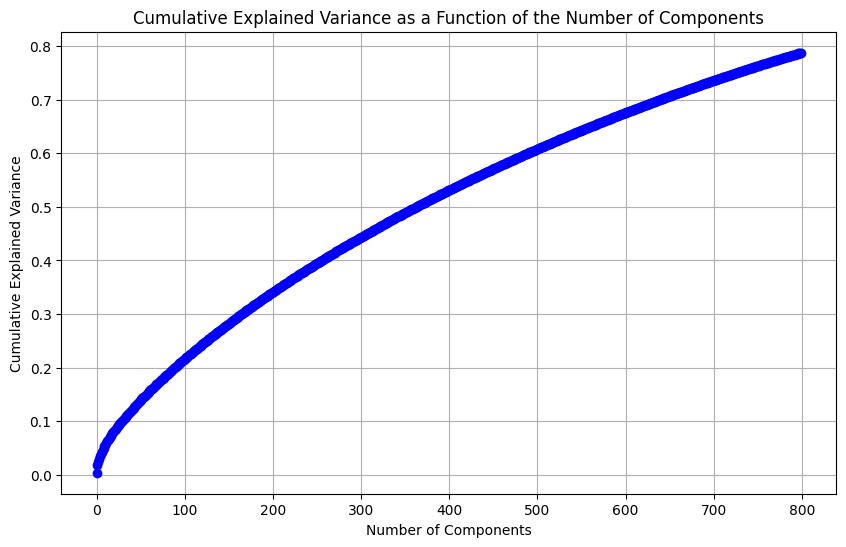

In [ ]:
# Calculate the cumulative sum of explained variance ratios
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='-', color='b')

# Add title and labels
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.grid(True)
plt.show()

In [ ]:
cumulative_explained_variance[-1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.7874810313402415

In [ ]:
800/X_tf.shape[1]
# We are explaining 79% of the variancce using 800 dimensions, 4.68% of the initial dimension

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.04685486704931475

In [ ]:
# Example to see the first component
component_1_loadings = svd.components_[1]
feature_names = tfidf.get_feature_names_out()
high_weight_features = sorted(zip(feature_names, component_1_loadings), key=lambda x: abs(x[1]), reverse=True)

for feature, loading in high_weight_features[:20]:
    print(f"{feature}: {loading}")

nan nan: 0.7160337793901334
nan: 0.6848322789850845
days: 0.02195432396338389
headspace nan: 0.020761908640705717
meditation nan: 0.01880980414452151
stories: 0.016905739844678375
proud: 0.01682851663441428
code: 0.014822161752154972
meditations: -0.014152155964963177
gate: 0.013698080091864932
would: -0.012580024408559543
headspace interface: 0.012028266324011567
interface nan: 0.012028266324011567
sleepcast stories: 0.011770271913682462
inconsistent: 0.011729188682164783
nan app: 0.011628413286047266
time: -0.01138393676554682
familiar: 0.011320783161736467
also: -0.011043396048265933
asking: 0.010891454516647048


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We are going to use the first method, Latent Dirichlet Allocation.

In [ ]:
#df2 = df.sample(frac=0.3, random_state=42)
#df2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,title,text,comments,replies to comments,subreddit,url,combined,combined_nonurl,tokens,tokens_nonstop
49,9/5/2024,Headspace cancelled my subscription before tri...,So I subscribed to Headspace via the Google Pl...,"[""I still have a spot on my family plan that's...","[""Hi!! Thank you so much, that is so so kind o...",Headspace,https://www.reddit.com/r/Headspace/comments/1f...,Headspace cancelled my subscription before tri...,"[Headspace, cancelled, my, subscription, befor...","[headspace, cancelled, subscription, before, t...","[headspace, cancelled, subscription, trial, pe..."
638,7/1/2022,Anyone selling a lifetime subscription account...,NaN,"['PM me.', 'Most libraries offer free subscrip...","['Did', 'None of that near me unfortunately.']",Headspace,https://www.reddit.com/r/Headspace/comments/vp...,Anyone selling a lifetime subscription account...,"[Anyone, selling, a, lifetime, subscription, a...","[anyone, selling, lifetime, subscription, acco...","[anyone, selling, lifetime, subscription, acco..."
1033,3/19/2021,Is anyone using the app with a VPN on their ph...,I always have VPN on and in the last 2 years t...,['What does VPN have to do with Headspace?'],['I use VPN to connect to the internet. Headsp...,HeadspaceApp,https://www.reddit.com/r/HeadspaceApp/comments...,Is anyone using the app with a VPN on their ph...,"[Is, anyone, using, the, app, with, a, VPN, on...","[anyone, using, the, app, with, vpn, their, ph...","[anyone, using, app, vpn, phone, experiencing,..."
746,4/5/2022,Discount for 3rd world countries,does the site offer discount based on geolocat...,['Salaam. If you look at the [pinned code ](ht...,"[""Sadly they don't offer student discount for ...",Headspace,https://www.reddit.com/r/Headspace/comments/tx...,Discount for 3rd world countries does the site...,"[Discount, for, 3rd, world, countries, does, t...","[discount, for, world, countries, does, the, s...","[discount, world, countries, site, offer, disc..."
918,11/24/2021,Let your mind do what it wants,"When the meditation guide says ""just let your ...","['Pretty much... \n\nDuring meditation:\n\n\n""...",['It illustrates very well how ones mind CAN b...,Headspace,https://www.reddit.com/r/Headspace/comments/r1...,Let your mind do what it wants When the medita...,"[Let, your, mind, do, what, it, wants, When, t...","[let, your, mind, what, wants, when, the, medi...","[let, mind, wants, meditation, guide, says, le..."


In [ ]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

texts = df['tokens_nonstop'].tolist()
full_texts =  df['combined'].tolist()
# Create a dictionary representation of the documents
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=0.001, no_above=0.90, keep_n=10000)


dictionary.compactify()

# Convert document into a bag of word, following gensim package
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
texts[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['longest',
 'run',
 'streak',
 'ever',
 'curious',
 'longest',
 'run',
 'streak',
 'app',
 'saw',
 'articles',
 'years',
 'ago',
 'said',
 'anyone',
 'beat',
 'somewhere',
 'purposely',
 'missed',
 'day',
 'became',
 'streak',
 'journey',
 'practice',
 'meditation',
 'mennim',
 'less',
 'consistent',
 'probably',
 'like',
 'days',
 'life',
 'happens',
 'free',
 'streak',
 'even',
 'needing',
 'something',
 'rather',
 'wanting',
 'freeing',
 'always',
 'wanted',
 'get',
 'never',
 'done',
 'highest',
 'something',
 'recently',
 'inadvertently',
 'busted',
 'day',
 'streak',
 'back',
 'inflatable',
 'meditation',
 'pillow',
 'lol',
 'something',
 'stress',
 'missing',
 'day',
 'though',
 'probably',
 'current',
 'one',
 'days',
 'habitual',
 'streak',
 'genuinely',
 'love',
 'meditating',
 'headspace',
 'daily',
 'basis',
 'sets',
 'day',
 'right',
 'years',
 'think',
 'could',
 'nto',
 'honest',
 'counting',
 'meditated',
 'every',
 'day',
 'since',
 'started',
 'days',
 'literally',
 

In [ ]:
num_topics = 5
passes = 10
random_state = 42

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=passes,
                     random_state=random_state,
                     eval_every=None)
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.011*"like" + 0.011*"mind" + 0.010*"thoughts" + 0.008*"think" + 0.007*"focus" + 0.007*"let" + 0.007*"would" + 0.007*"breath" + 0.007*"meditation" + 0.007*"headspace"')
(1, '0.021*"headspace" + 0.008*"would" + 0.008*"one" + 0.008*"code" + 0.008*"like" + 0.008*"free" + 0.007*"anyone" + 0.007*"app" + 0.007*"day" + 0.007*"know"')
(2, '0.027*"headspace" + 0.023*"app" + 0.011*"meditation" + 0.011*"free" + 0.009*"like" + 0.007*"use" + 0.006*"subscription" + 0.006*"get" + 0.005*"meditations" + 0.005*"apps"')
(3, '0.020*"meditation" + 0.012*"headspace" + 0.012*"app" + 0.011*"like" + 0.008*"time" + 0.007*"course" + 0.007*"meditations" + 0.007*"really" + 0.006*"get" + 0.006*"find"')
(4, '0.012*"one" + 0.012*"like" + 0.011*"sleepcasts" + 0.011*"sleep" + 0.009*"new" + 0.007*"headspace" + 0.007*"sleepcast" + 0.007*"love" + 0.007*"night" + 0.006*"nan"')


In [ ]:
#function to create the word cloud for visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generate_wordcloud(lda_model, topic_id):
    topic_words = lda_model.show_topic(topic_id, topn=50)
    word_freq = {word: weight for word, weight in topic_words}
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
    return wordcloud

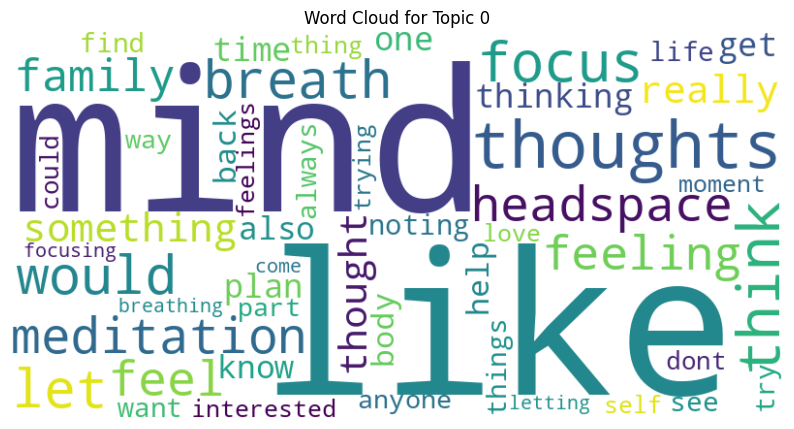

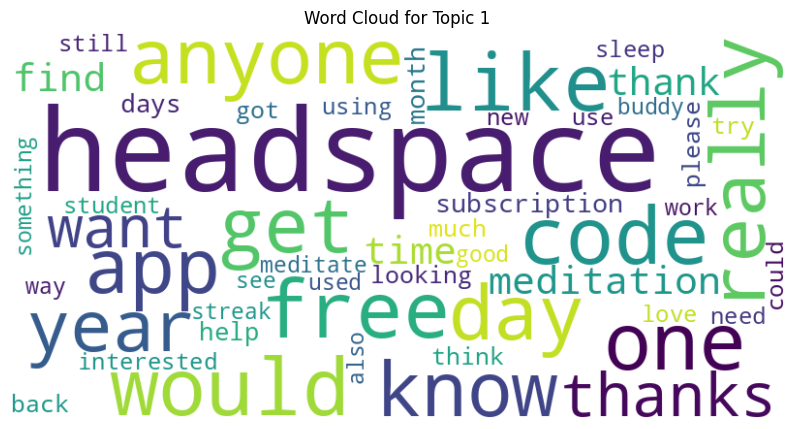

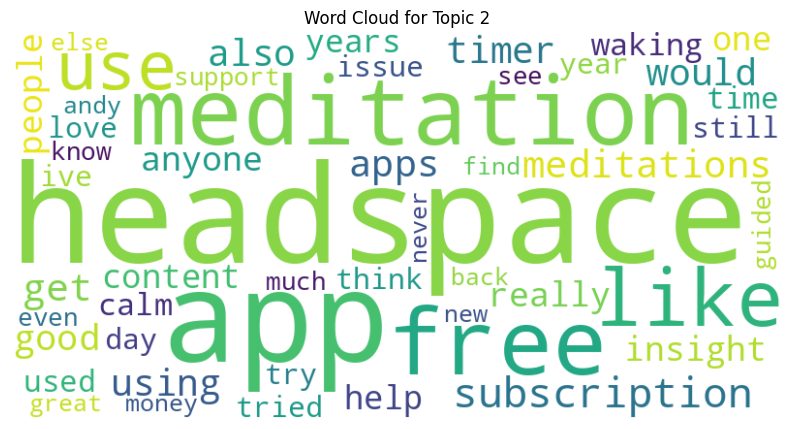

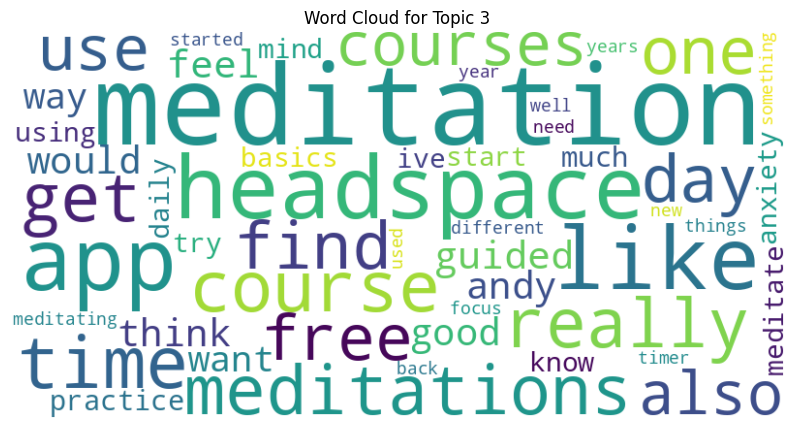

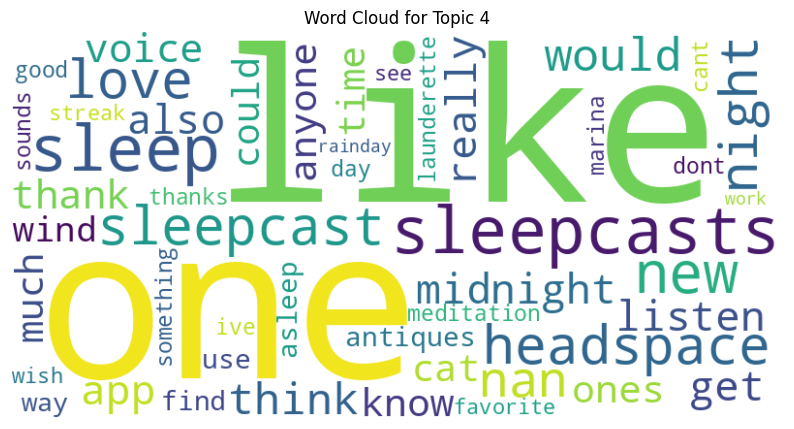

In [ ]:
for topic_id in range(num_topics):
    wordcloud = generate_wordcloud(lda_model, topic_id)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_id}")
    plt.show()

In [ ]:
num_topics = 4
passes = 10
random_state = 42

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=passes,
                     random_state=random_state,
                     eval_every=None)
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.019*"headspace" + 0.013*"app" + 0.012*"meditation" + 0.011*"like" + 0.007*"one" + 0.007*"get" + 0.006*"free" + 0.006*"meditations" + 0.006*"would" + 0.006*"use"')
(1, '0.010*"mind" + 0.010*"meditation" + 0.009*"like" + 0.007*"focus" + 0.006*"thoughts" + 0.006*"think" + 0.005*"headspace" + 0.005*"get" + 0.005*"breath" + 0.005*"body"')
(2, '0.015*"headspace" + 0.010*"app" + 0.008*"meditation" + 0.007*"course" + 0.006*"like" + 0.006*"anyone" + 0.005*"day" + 0.005*"get" + 0.005*"really" + 0.004*"using"')
(3, '0.008*"like" + 0.008*"headspace" + 0.008*"one" + 0.006*"app" + 0.006*"sleep" + 0.006*"would" + 0.005*"get" + 0.005*"meditation" + 0.005*"want" + 0.004*"know"')


In [ ]:
num_topics = 3
passes = 10
random_state = 42

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=passes,
                     random_state=random_state,
                     eval_every=None)
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.018*"headspace" + 0.013*"app" + 0.011*"meditation" + 0.010*"like" + 0.007*"one" + 0.007*"get" + 0.006*"would" + 0.006*"free" + 0.005*"new" + 0.005*"use"')
(1, '0.010*"like" + 0.008*"mind" + 0.008*"meditation" + 0.006*"think" + 0.005*"thoughts" + 0.005*"get" + 0.005*"focus" + 0.005*"headspace" + 0.004*"app" + 0.004*"one"')
(2, '0.012*"headspace" + 0.007*"app" + 0.007*"meditation" + 0.006*"like" + 0.005*"course" + 0.005*"day" + 0.005*"one" + 0.004*"anyone" + 0.004*"feel" + 0.004*"also"')


In [ ]:
num_topics = 6
passes = 10
random_state = 42

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=passes,
                     random_state=random_state,
                     eval_every=None)
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.020*"headspace" + 0.016*"app" + 0.013*"meditation" + 0.012*"like" + 0.008*"one" + 0.007*"meditations" + 0.006*"get" + 0.006*"use" + 0.006*"would" + 0.006*"free"')
(1, '0.005*"mind" + 0.005*"meditation" + 0.005*"mountain" + 0.004*"focus" + 0.004*"headspace" + 0.004*"like" + 0.004*"see" + 0.004*"time" + 0.004*"get" + 0.003*"always"')
(2, '0.016*"headspace" + 0.011*"app" + 0.009*"meditation" + 0.006*"subscription" + 0.005*"anyone" + 0.004*"day" + 0.004*"using" + 0.004*"really" + 0.004*"feel" + 0.004*"time"')
(3, '0.009*"like" + 0.009*"one" + 0.008*"headspace" + 0.007*"app" + 0.007*"sleep" + 0.006*"want" + 0.006*"meditation" + 0.006*"nan" + 0.006*"would" + 0.005*"really"')
(4, '0.012*"like" + 0.011*"headspace" + 0.009*"meditation" + 0.008*"mind" + 0.008*"would" + 0.007*"get" + 0.007*"thoughts" + 0.006*"think" + 0.006*"focus" + 0.005*"know"')
(5, '0.008*"headspace" + 0.007*"get" + 0.007*"day" + 0.006*"like" + 0.006*"think" + 0.005*"one" + 0.005*"good" + 0.005*"meditation" + 0.004*"ti

In [ ]:
! pip install pyldavis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.0 MB/s eta 0:00:00


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# I would prefer to use 5 topics
# see the distribution of topics by document on average.
num_topics = lda_model.num_topics
topic_coverage = np.zeros(num_topics)

for doc_bow in corpus:
    for topic_id, proportion in lda_model.get_document_topics(doc_bow, minimum_probability=0):
        topic_coverage[topic_id] += proportion

# Normalize by the number of documents to get the average coverage
topic_coverage /= len(corpus)

for topic_id, coverage in enumerate(topic_coverage):
    print(f"Topic {topic_id}: {coverage * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0: 12.67%
Topic 1: 22.06%
Topic 2: 19.81%
Topic 3: 26.02%
Topic 4: 19.43%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


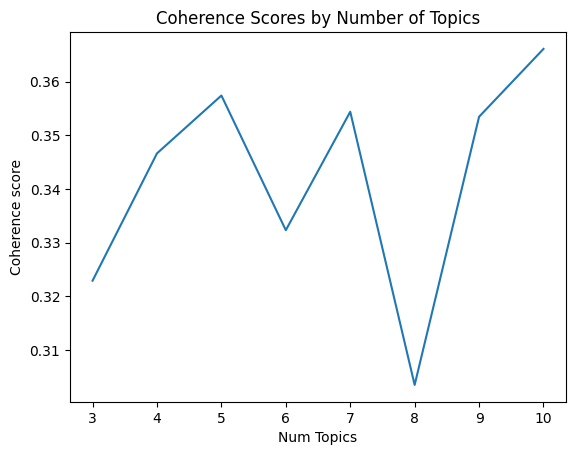

Num Topics = 3, Coherence Value = 0.3229
Num Topics = 4, Coherence Value = 0.3466
Num Topics = 5, Coherence Value = 0.3574
Num Topics = 6, Coherence Value = 0.3323
Num Topics = 7, Coherence Value = 0.3544
Num Topics = 8, Coherence Value = 0.3035
Num Topics = 9, Coherence Value = 0.3535
Num Topics = 10, Coherence Value = 0.3661


In [ ]:
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import numpy as np

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    for num_topics in range(start, limit + 1, step):
        # Create a new LDA model for each number of topics
        id2word = dictionary.id2token

        model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,
                         passes=passes, eval_every=None)
        # Compute the coherence score for the model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

# Parameters for the coherence computation
start, limit, step = 3, 10, 1

# Ensure your 'texts', 'dictionary', and 'corpus' are correctly prepared before this step
coherence_values = compute_coherence_values(dictionary, corpus, texts, start, limit, step)

# Plotting the coherence scores
x = range(start, limit + 1, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores by Number of Topics")
plt.show()

# Printing the coherence scores for each number of topics
for num_topics, coherence_value in zip(x, coherence_values):
    print(f"Num Topics = {num_topics}, Coherence Value = {round(coherence_value, 4)}")


In [ ]:
texts = df['tokens_nonstop']
print(texts[200])

['looking', 'certain', 'meditation', 'help', 'hello', 'everyone', 'using', 'app', 'years', 'recently', 'discovered', 'remember', 'certain', 'meditation', 'used', 'love', 'via', 'andy', 'voice', 'kind', 'light', 'entering', 'body', 'remember', 'felt', 'amazing', 'recall', 'name', 'anyone', 'idea', 'still', 'app', 'andy', 'cover', 'hello', 'sunshine', 'search', 'balance', 'app', 'app']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
document_topics = lda_model.get_document_topics(corpus[200])

for topic_id, topic_proportion in document_topics:
    print(f"Topic {topic_id}: {topic_proportion * 100:.2f}%")

Topic 1: 40.89%
Topic 3: 57.60%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# add a colum to show the topic that the post belongs to
highest_topics = []

# find the topic with the highest proportion, (topic_id, topic_proportion)
for doc in corpus:
    document_topics = lda_model.get_document_topics(doc)
    highest_topic = max(document_topics, key=lambda x: x[1])
    highest_topics.append(highest_topic)

df['Topic_LDA'] = [topic[0] for topic in highest_topics]
df.head()

,date,title,text,comments,replies to comments,subreddit,url,combined,combined_nonurl,tokens,tokens_nonstop,Topic_LDA
0,11/22/2024,What's the longest run streak ever?,I'm curious about what the longest run streak ...,['I was somewhere up into the 1700\'s before I...,[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,What's the longest run streak ever? I'm curiou...,"[What, 's, the, longest, run, streak, ever, ?,...","[what, the, longest, run, streak, ever, curiou...","[longest, run, streak, ever, curious, longest,...",4
1,11/20/2024,Quality is lacking,I tried the new meditation about finding post ...,['The app was better when it was just Andy. I ...,"['What happened to Andy?', 'I signed up again ...",Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Quality is lacking I tried the new meditation ...,"[Quality, is, lacking, I, tried, the, new, med...","[quality, lacking, tried, the, new, meditation...","[quality, lacking, tried, new, meditation, fin...",2
2,11/18/2024,Possible bug in app?,When I connect my Bluetooth headphones to my p...,"[""That is a bug in your phone or Bluetooth dev...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Possible bug in app? When I connect my Bluetoo...,"[Possible, bug, in, app, ?, When, I, connect, ...","[possible, bug, app, when, connect, bluetooth,...","[possible, bug, app, connect, bluetooth, headp...",2
3,11/18/2024,Headspace Issue - Has there been any statement...,Just installed Headspace. I want to restart my...,"['I am facing the same issue.', 'Have you trie...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Headspace Issue - Has there been any statement...,"[Headspace, Issue, -, Has, there, been, any, s...","[headspace, issue, has, there, been, any, stat...","[headspace, issue, statements, headspace, inst...",3
4,11/13/2024,VR in Headspace or similar?,Hey Headspace community! üëã\n\nI‚Äôm gatheri...,[],[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,VR in Headspace or similar? Hey Headspace comm...,"[VR, in, Headspace, or, similar, ?, Hey, Heads...","[headspace, similar, hey, headspace, community...","[headspace, similar, hey, headspace, community...",2


In [ ]:
df.to_csv("/content/gdrive/MyDrive/withLDAtopic.csv", index=False, encoding="utf-8")
# please use this for combined analysis

Let us now do k-means clustering.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
X_tf = X_tf.todense()
X_tf = np.asarray(X_tf)

X3 = X3.todense()
X3 = np.asarray(X3)

In [ ]:
# Calculate inertia for a range of k values
inertias = []
k_range = range(1,60)  # Adjust the range of k as needed
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_tf)
    inertias.append(kmeans.inertia_)

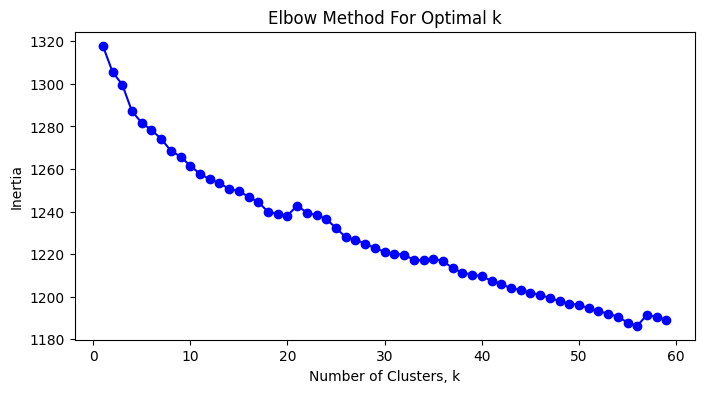

In [ ]:
# Plot the elbow graph
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# check how are they matched to their cluster
sil_scores = []
for n in range(2, 21):
    km = KMeans(n_clusters=n, n_init='auto', random_state=42)
    km.fit(X_tf)
    sil_scores.append(silhouette_score(X_tf, km.labels_))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


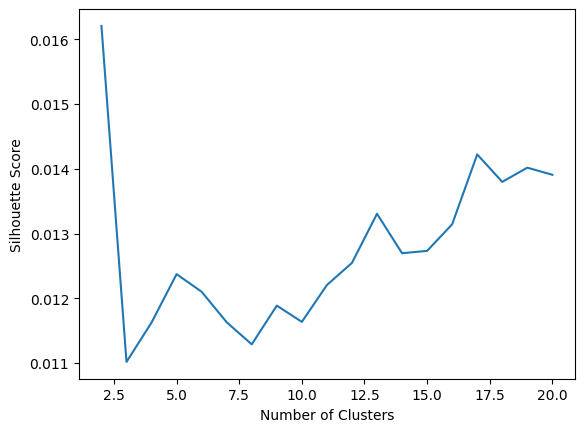

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(2, 21), sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()
# decided the number of clusters is 17

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For n_clusters = 5, The average silhouette_score is : 0.012372923716766817
For n_clusters = 6, The average silhouette_score is : 0.012100577710626967
For n_clusters = 16, The average silhouette_score is : 0.013142595611901743
For n_clusters = 17, The average silhouette_score is : 0.014222738528240608
For n_clusters = 18, The average silhouette_score is : 0.013798729505793542


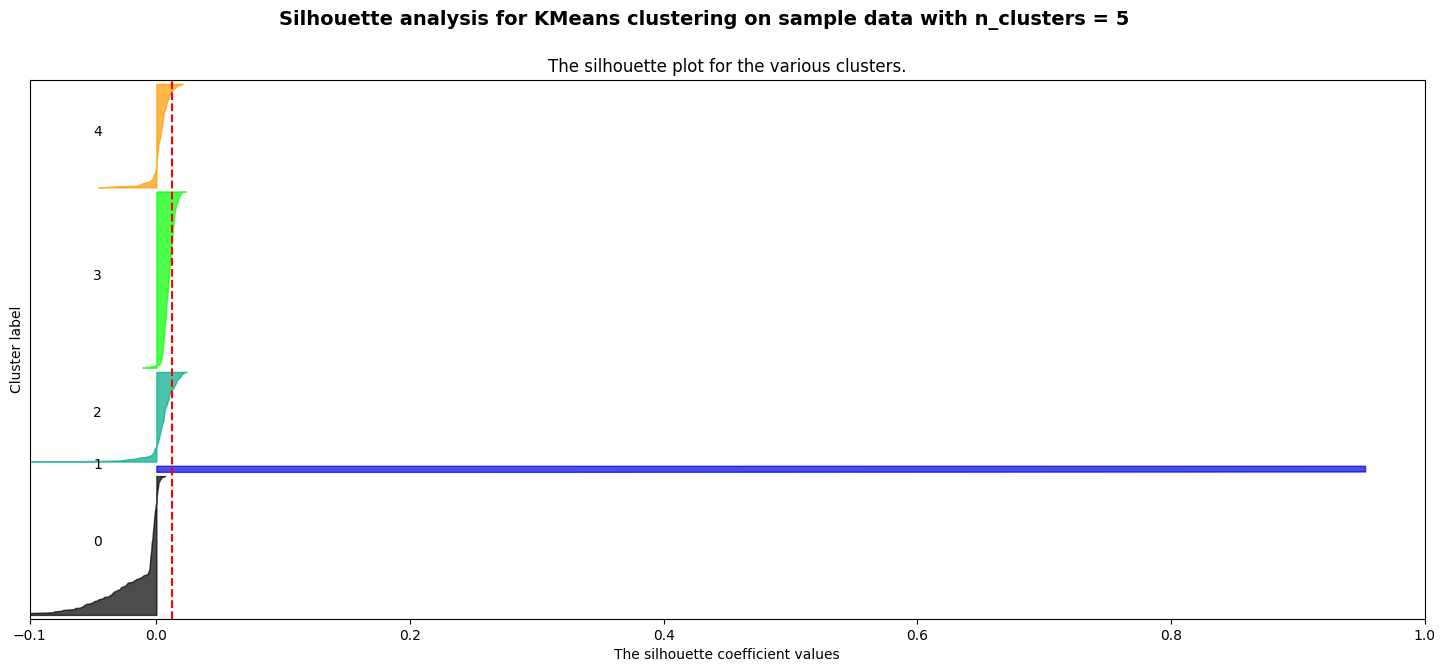

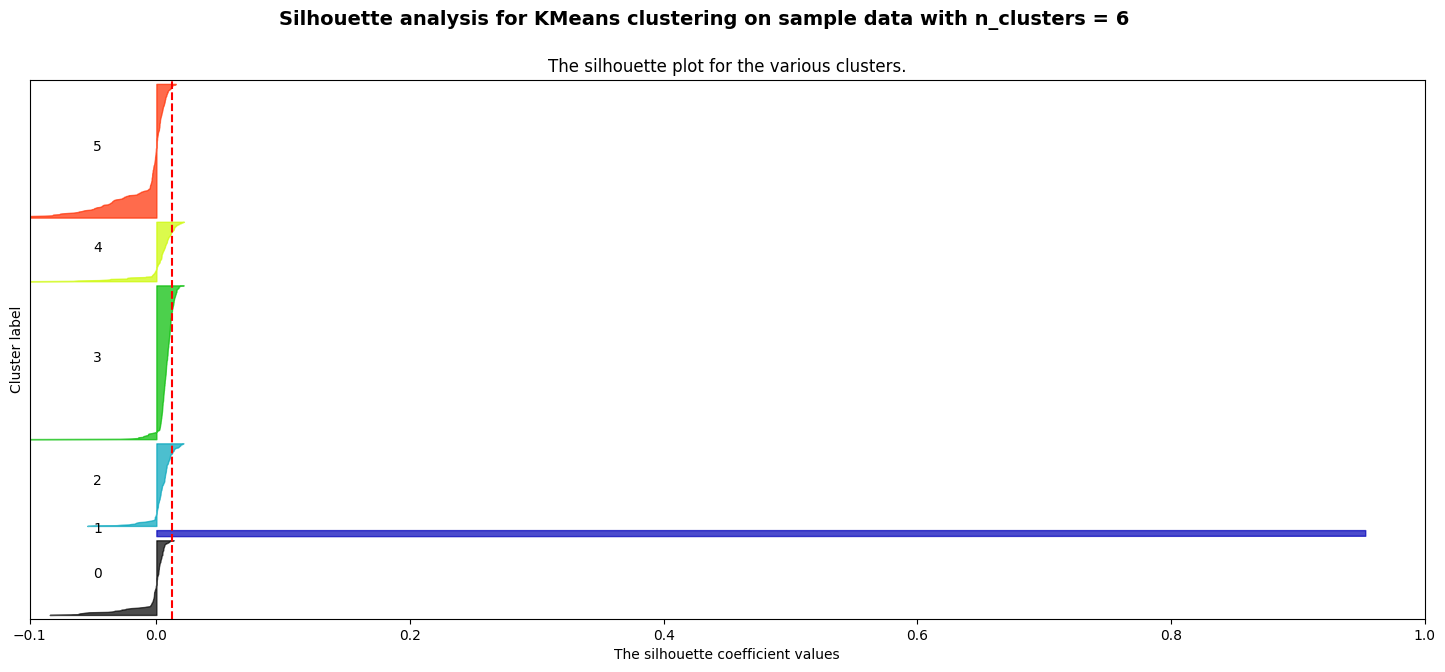

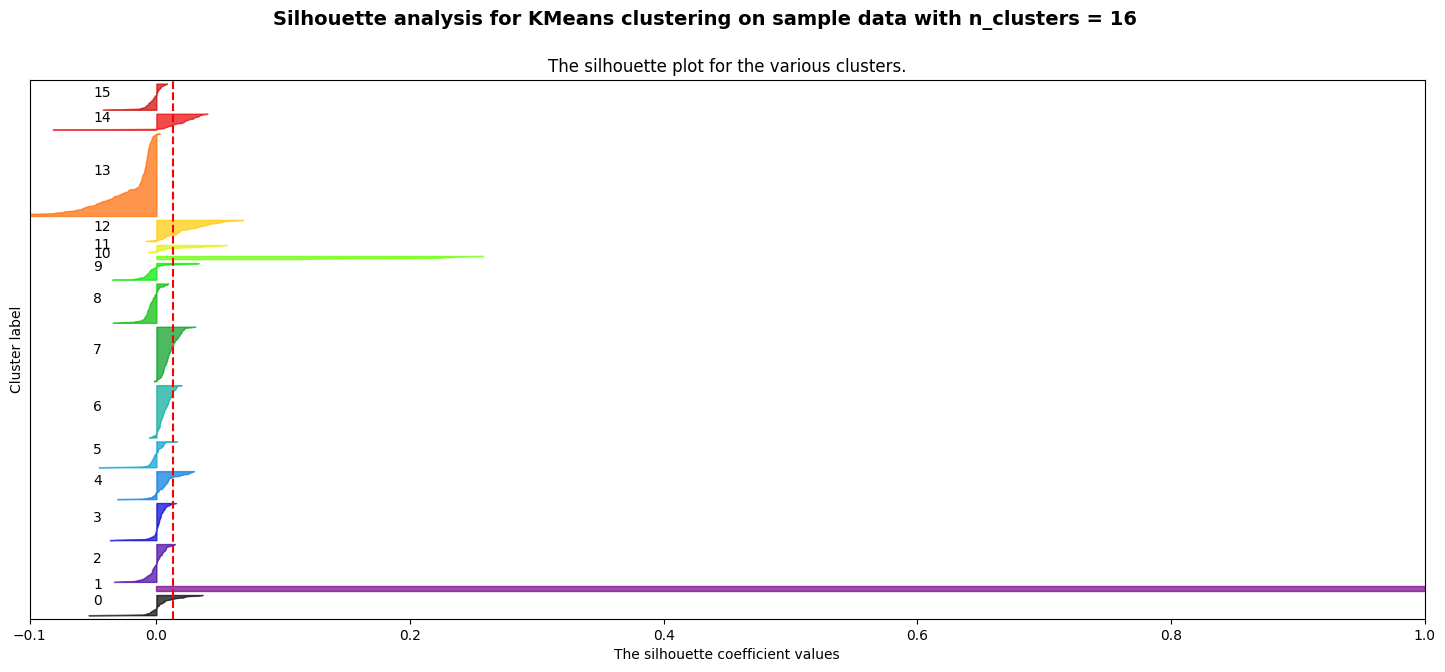

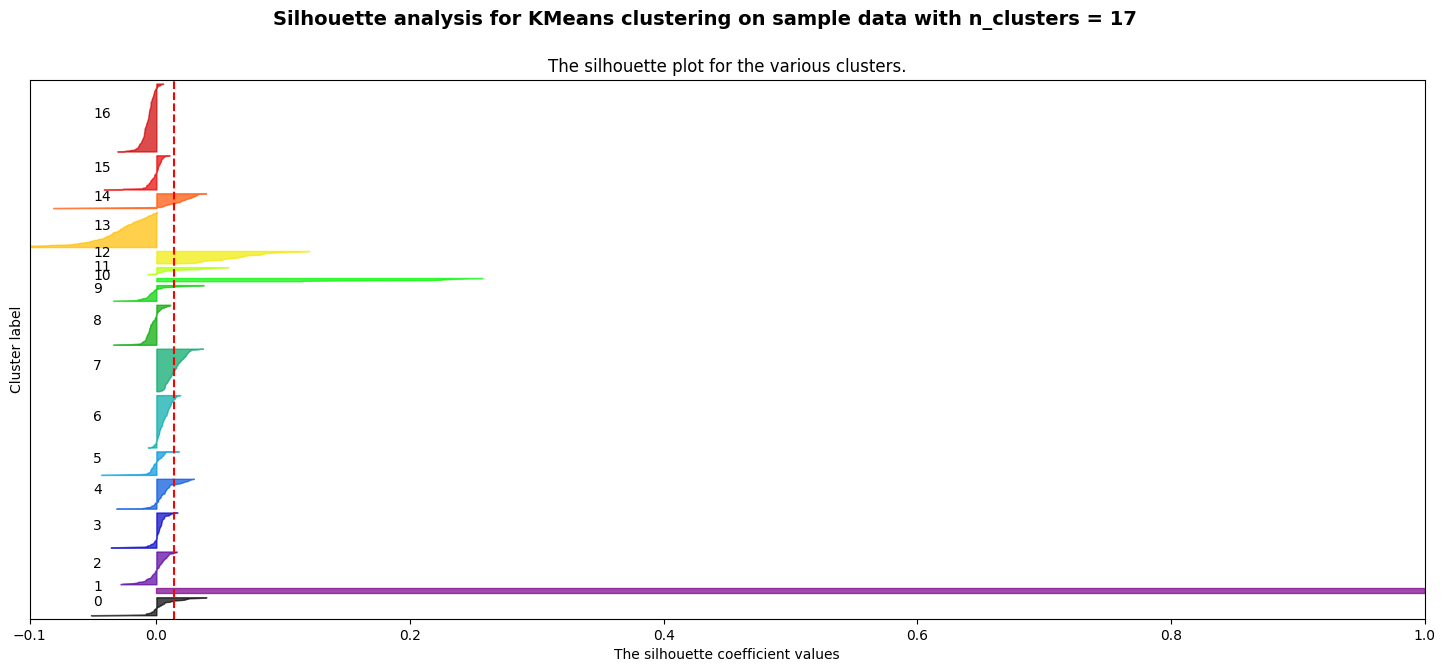

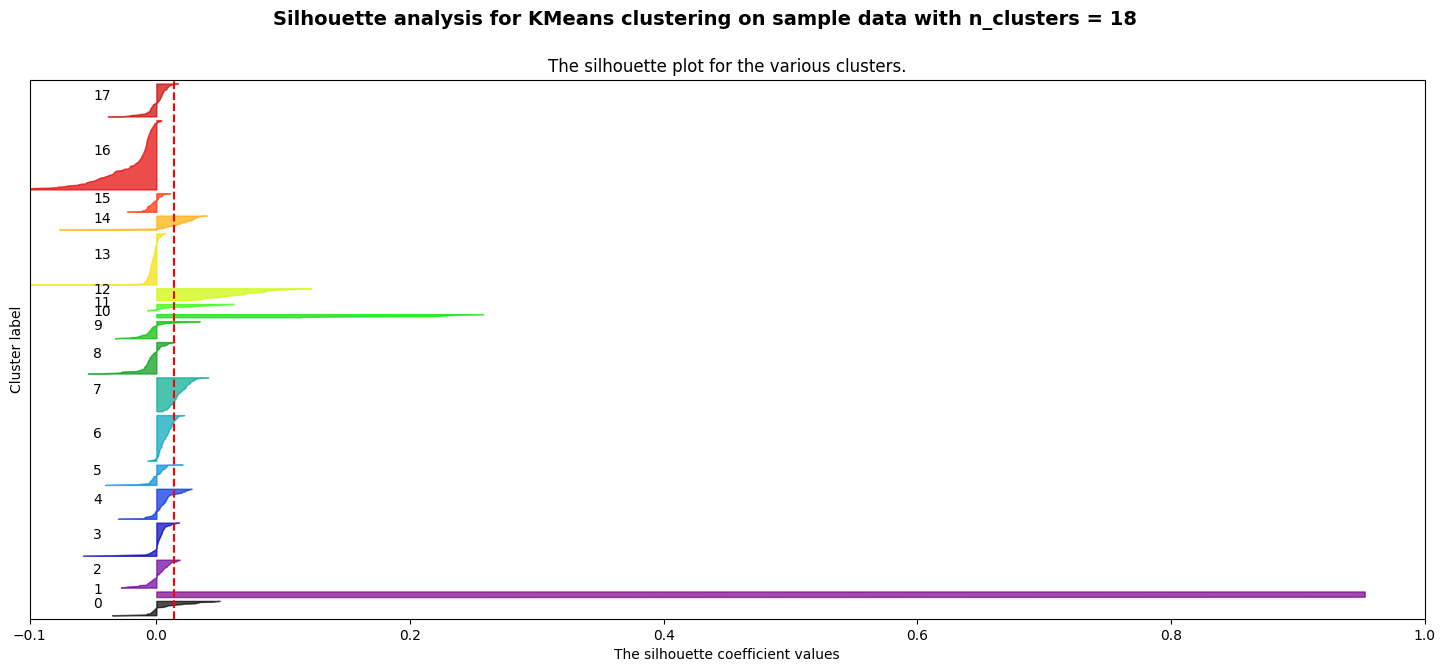

In [ ]:
import matplotlib.cm as cm

# Assuming X is your dataset
range_n_clusters = [5,6,16,17,18] #INSERT A NUMBER OR A RANGE

for n_clusters in range_n_clusters:
    # Create a subplot
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # Set limits for the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # Inserting blank space between silhouette plots of individual clusters
    ax1.set_ylim([0, X_tf.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    cluster_labels = clusterer.fit_predict(X_tf)

    # The silhouette_score gives the average value for all the samples
    silhouette_avg = silhouette_score(X_tf, cluster_labels)
    print(f"For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_tf, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate and sort silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers in the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}", fontsize=14, fontweight="bold")

plt.show()

In [ ]:
clusters = KMeans(n_clusters=17, n_init='auto', random_state=42)
cluster_labels = clusters.fit_predict(X_tf)
cluster_labels = pd.DataFrame(cluster_labels, columns=['cluster'])
cluster_labels.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cluster
0,13
1,7
2,5
3,5
4,16
5,3
6,1
7,1
8,3
9,6


In [ ]:
merged_df = df.merge(cluster_labels, left_index=True, right_index=True)
merged_df['text'] = merged_df['tokens'].apply(' '.join)
merged_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,title,text,comments,replies to comments,subreddit,url,combined,tokens,tokens_nonstop,combined_nonurl,cluster
0,11/22/2024,What's the longest run streak ever?,what the longest run streak ever curious about...,['I was somewhere up into the 1700\'s before I...,[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,What's the longest run streak ever? I'm curiou...,"[what, the, longest, run, streak, ever, curiou...","[longest, run, streak, ever, curious, longest,...","[What, 's, the, longest, run, streak, ever, ?,...",13
1,11/20/2024,Quality is lacking,quality lacking tried the new meditation about...,['The app was better when it was just Andy. I ...,"['What happened to Andy?', 'I signed up again ...",Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Quality is lacking I tried the new meditation ...,"[quality, lacking, tried, the, new, meditation...","[quality, lacking, tried, new, meditation, fin...","[Quality, is, lacking, I, tried, the, new, med...",7
2,11/18/2024,Possible bug in app?,possible bug app when connect bluetooth headph...,"[""That is a bug in your phone or Bluetooth dev...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Possible bug in app? When I connect my Bluetoo...,"[possible, bug, app, when, connect, bluetooth,...","[possible, bug, app, connect, bluetooth, headp...","[Possible, bug, in, app, ?, When, I, connect, ...",5
3,11/18/2024,Headspace Issue - Has there been any statement...,headspace issue has there been any statements ...,"['I am facing the same issue.', 'Have you trie...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Headspace Issue - Has there been any statement...,"[headspace, issue, has, there, been, any, stat...","[headspace, issue, statements, headspace, inst...","[Headspace, Issue, -, Has, there, been, any, s...",5
4,11/13/2024,VR in Headspace or similar?,headspace similar hey headspace community gath...,[],[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,VR in Headspace or similar? Hey Headspace comm...,"[headspace, similar, hey, headspace, community...","[headspace, similar, hey, headspace, community...","[VR, in, Headspace, or, similar, ?, Hey, Heads...",16


In [ ]:
from wordcloud import WordCloud

def generate_wordcloud_for_cluster(cluster_number, df, matrix, vectorizer):
    """
    Generates and displays a word cloud for a specific cluster based on vectorizer scores.

    Parameters:
    - cluster_number: The cluster number for which to generate the word cloud.
    - df: The DataFrame containing 'cluster' column.
    - matrix: The pre-computed vectorizer matrix.
    - vectorizer: The vectorizer instance used to transform the text data.
    """
    # Filter the DataFrame for the specified cluster
    cluster_mask = df['cluster'] == cluster_number
    cluster_df = df[cluster_mask]
    print(f"Number of artists in cluster {cluster_number}: {len(cluster_df)}")

    cluster_matrix = matrix[cluster_mask]
    cluster_scores = np.asarray(cluster_matrix.sum(axis=0)).flatten()

    # Create a dictionary of term-score pairs
    word_scores_dict = {term: cluster_scores[index] for term, index in vectorizer.vocabulary_.items()}

    # Generate the word cloud from scores
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(word_scores_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Cluster {cluster_number}")
    plt.axis('off')  # Do not show axes to keep it clean
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of artists in cluster 5: 68


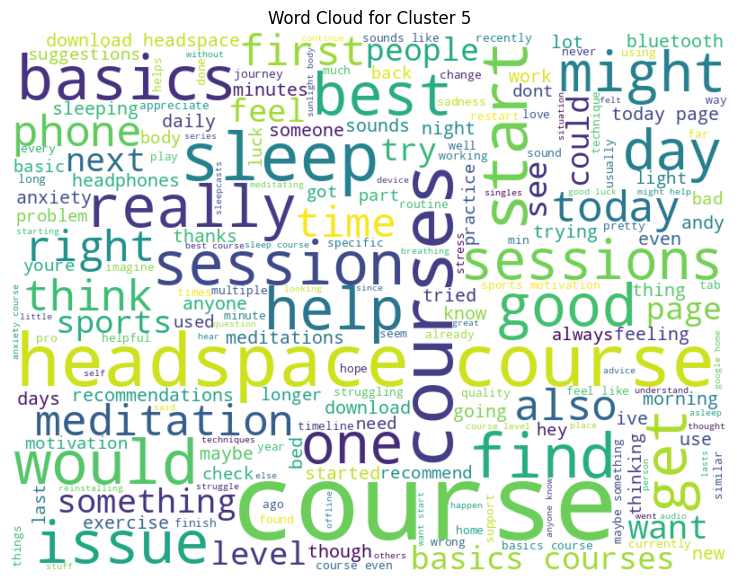

In [ ]:
generate_wordcloud_for_cluster(5, merged_df, X_tf, tfidf)

Then, let's try BERT.

In [ ]:
import pandas as pd
# Read original data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/headspace_submissions_v2.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this section, we prepared the data differently for BERTopic. This time, we focus solely on the text part of the Reddit submissions.

We keep the texts as they are to ensure the model captures the full context. For cleaness and consistency, we remove urls and combine the paragraphs, which in most cases are just short sentences. For longer texts, we don't combine the paragraphs but split them into separated analysis documents.

In [ ]:
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.2.1
    Uninstalling sentence-transformers-3.2.1:
      Successfully uninstalled sentence-transformers-3.2.1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
! pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00


### Data preparation for BERTopic

In [ ]:
# Remove urls form text
import re

def remove_urls(text):
    url_pattern = r'http[s]?://\S+|www\.\S+'
    return re.sub(url_pattern, '', str(text))

df['text'] = df['text'].apply(remove_urls)
df['comments'] = df['comments'].apply(remove_urls)
df['replies to comments'] = df['replies to comments'].apply(remove_urls)

In [ ]:
# Drop if no text
df= df.dropna(subset=['text'])
df = df[df['text'] != 'nan']
len(df)

1139

In [ ]:
# Create text that combines paragraph
df['text_unformatted'] = df['text'].apply(lambda x: re.sub(r'\n+', ' ', x))
df['text_unformatted'] = df['text_unformatted'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

In [ ]:
# Use sentence transformers to count tokens in text
tokenizer = model.tokenizer
df['text_token_count'] = df['text_unformatted'].apply(lambda x: len(tokenizer.tokenize(x)))
df['text_token_count'].describe()

Token indices sequence length is longer than the specified maximum sequence length for this model (1224 > 384). Running this sequence through the model will result in indexing errors


,text_token_count
count,1139.000000
mean,97.339772
std,124.115243
min,0.000000
25%,42.000000
50%,70.000000
75%,109.000000
max,2085.000000


In [ ]:
# Create a list that stores short enough text for SentenceTransformer and BERT
text = []
for index, row in df.iterrows():
  if row['text_token_count'] < 512 and row['text_token_count'] > 0:
    text.append(row['text_unformatted'])
  else:
    paragraphs = re.split(r'\n+', row['text'])
    for paragraph in paragraphs:
      paragraph_cleaned = re.sub(r'\s+', ' ', paragraph).strip()
      if len(tokenizer.tokenize(paragraph_cleaned)) < 512:
        text.append(paragraph_cleaned)

In [ ]:
# Creat embeddings of text using SentenceTransformer
text_embeddings_mpnet = model.encode(text)

### Initialize BERTopic model and train it

In [ ]:
from bertopic import BERTopic
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer

In [ ]:
# Initialize other pipeline models in BERTopic
# umap model
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# hdbscan model
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=60, metric='euclidean', cluster_selection_method='leaf', prediction_data=True)

# vectorizer model
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), lowercase=True)

# representation model
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech # What does OpenAI does?
keybert_model = KeyBERTInspired()

mmr_model = MaximalMarginalRelevance(diversity=0.3)

pos_model = PartOfSpeech("en_core_web_sm")

representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model
}

In [ ]:
# Initialize an instance of BERTopic
topic_model = BERTopic(

  # Pipeline models
  embedding_model=model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=15,
  verbose=True,
  calculate_probabilities=True
  )

# Train model
topics, probs = topic_model.fit_transform(text, text_embeddings_mpnet)

2024-12-04 20:14:28,448 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-04 20:14:44,054 - BERTopic - Dimensionality - Completed ✓
2024-12-04 20:14:44,055 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-04 20:14:44,160 - BERTopic - Cluster - Completed ✓
2024-12-04 20:14:44,171 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-04 20:15:30,007 - BERTopic - Representation - Completed ✓


### Results of BERTopic

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,POS,Representative_Docs
0,-1,516,-1_headspace_app_just_meditation,"[headspace, app, just, meditation, like, ve, t...","[subscription, cancel, headspace, refund, apps...","[headspace, app, meditation, time, subscriptio...","[headspace, app, meditation, time, year, subsc...",[Just wanted to give people a heads up that He...
1,0,491,0_meditation_headspace_like_app,"[meditation, headspace, like, app, just, ve, f...","[guided meditation, meditation, meditating, me...","[meditation, headspace, app, feel, day, focus,...","[meditation, headspace, app, time, day, though...","[For a bit of context, she fell out of love wi..."
2,1,153,1_sleepcasts_sleep_sleepcast_like,"[sleepcasts, sleep, sleepcast, like, headspace...","[sleepcasts, headspace sleep, sleepcast, sleep...","[sleepcasts, sleep, sleepcast, headspace, nigh...","[sleepcasts, sleep, sleepcast, headspace, just...",[I listen to Headspace’s Sleepcasts nightly to...
3,2,131,2_code_headspace_free_plan,"[code, headspace, free, plan, month, family, s...","[headspace app, free month, months free, promo...","[headspace, free, subscription, discount, app,...","[code, headspace, free, plan, month, family, s...","[I did a 15 day streak on Headspace, re doing ..."


In [ ]:
# Show topics of documents
df_BERT = topic_model.get_document_info(text)
df_BERT.head()

,Document,Topic,Name,Representation,KeyBERT,MMR,POS,Representative_Docs,Top_n_words,Probability,Representative_document
0,I'm curious about what the longest run streak ...,-1,-1_headspace_app_just_meditation,"[headspace, app, just, meditation, like, ve, t...","[subscription, cancel, headspace, refund, apps...","[headspace, app, meditation, time, subscriptio...","[headspace, app, meditation, time, year, subsc...",[Just wanted to give people a heads up that He...,headspace - app - just - meditation - like - v...,0.579540,False
1,I tried the new meditation about finding post ...,-1,-1_headspace_app_just_meditation,"[headspace, app, just, meditation, like, ve, t...","[subscription, cancel, headspace, refund, apps...","[headspace, app, meditation, time, subscriptio...","[headspace, app, meditation, time, year, subsc...",[Just wanted to give people a heads up that He...,headspace - app - just - meditation - like - v...,0.302328,False
2,When I connect my Bluetooth headphones to my p...,-1,-1_headspace_app_just_meditation,"[headspace, app, just, meditation, like, ve, t...","[subscription, cancel, headspace, refund, apps...","[headspace, app, meditation, time, subscriptio...","[headspace, app, meditation, time, year, subsc...",[Just wanted to give people a heads up that He...,headspace - app - just - meditation - like - v...,0.311349,False
3,Just installed Headspace. I want to restart my...,-1,-1_headspace_app_just_meditation,"[headspace, app, just, meditation, like, ve, t...","[subscription, cancel, headspace, refund, apps...","[headspace, app, meditation, time, subscriptio...","[headspace, app, meditation, time, year, subsc...",[Just wanted to give people a heads up that He...,headspace - app - just - meditation - like - v...,0.334615,False
4,Hey Headspace community! 👋 I’m gathering insig...,0,0_meditation_headspace_like_app,"[meditation, headspace, like, app, just, ve, f...","[guided meditation, meditation, meditating, me...","[meditation, headspace, app, feel, day, focus,...","[meditation, headspace, app, time, day, though...","[For a bit of context, she fell out of love wi...",meditation - headspace - like - app - just - v...,0.285692,False


In [ ]:
# # Save BERTopic info to csv
# # If you want to save labeled data, uncomment below
# df_BERT_info = topic_model.get_topic_info()
# drive.mount('/content/drive')
# file_path = '/content/drive/My Drive/headspace_bertopic_info.csv'
# df_BERT_info.to_csv(file_path, index=False)
# print(f"File saved to: {file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File saved to: /content/drive/My Drive/headspace_bertopic_info.csv


# Part 5: Sentiment Analysis

### Data Preparation

In [ ]:
# Read original data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/headspace_submissions_v2.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Remove urls form text
import re

def remove_urls(text):
    url_pattern = r'http[s]?://\S+|www\.\S+'
    return re.sub(url_pattern, '', str(text))

df['text'] = df['text'].apply(remove_urls)
df['comments'] = df['comments'].apply(remove_urls)
df['replies to comments'] = df['replies to comments'].apply(remove_urls)

In [ ]:
len(df)

1332

In [ ]:
# Drop if no text
df= df.dropna(subset=['text'])
df = df[df['text'] != 'nan']
len(df)

1139

In [ ]:
# Use transformers to label sentiment of text
! pip install datasets
! pip install transformers[torch]
! pip install accelerate -U
! pip install -U transformers
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 62.4 MB/s eta 0:00:00
  At

I checked the sentiment labeled by longformer, the accuracy is too low. I then used the twitter-roberta model to analyze the title of long text, and manually checked the sentiment of the 12 long texts. The accuracy reached 10/12, which exceeds that of longformer. After this, I relabelled the misclassified long text to achieve higher accuracy.

In [ ]:
# We initialize two classifiers, one for short text and one for long text
from transformers import pipeline, LongformerTokenizer, LongformerForSequenceClassification
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
# Label text length to distinguish long text entries from short text entries
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

text_lenth = []
for row in df['text']:
  tokens = tokenizer.encode(row, add_special_tokens=True)
  text_lenth.append(len(tokens))

df['text_length'] = text_lenth

In [ ]:
# Label text sentiment into positive, neutral or negative
text_sentiment = []
for index, row in df.iterrows():
  if row['text_length'] > 512:
    text_sentiment.append(classifier(row['title'])[0]['label'])
  else:
    text_sentiment.append(classifier(row['text'])[0]['label'])
df['sentiment'] = text_sentiment

In [ ]:
# Manually correct the misclassified labels
df.loc[316, 'sentiment'] = 'negative'
df.loc[394, 'sentiment'] = 'negative'

In [ ]:
# # If you want to save labeled data, uncomment below
# from google.colab import drive
# drive.mount('/content/drive')
# file_path = '/content/drive/My Drive/headspace_sentiment.csv'
# df.to_csv(file_path, index=False)
# print(f"File saved to: {file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File saved to: /content/drive/My Drive/headspace_sentiment.csv


### Analysis of Sentiment labels

In [ ]:
df.head()

,date,title,text,comments,replies to comments,subreddit,url,text_length,sentiment
0,2024-11-22,What's the longest run streak ever?,I'm curious about what the longest run streak ...,['I was somewhere up into the 1700\'s before I...,[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,37,neutral
1,2024-11-20,Quality is lacking,I tried the new meditation about finding post ...,['The app was better when it was just Andy. I ...,"['What happened to Andy?', 'I signed up again ...",Headspace,https://www.reddit.com/r/Headspace/comments/1g...,52,negative
2,2024-11-18,Possible bug in app?,When I connect my Bluetooth headphones to my p...,"[""That is a bug in your phone or Bluetooth dev...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,63,neutral
3,2024-11-18,Headspace Issue - Has there been any statement...,Just installed Headspace. I want to restart my...,"['I am facing the same issue.', 'Have you trie...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,86,negative
4,2024-11-13,VR in Headspace or similar?,Hey Headspace community! 👋\n\nI’m gathering in...,[],[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,90,positive


In [ ]:
example_negative = df[df['sentiment'] == 'negative']
example_negative.head()

,date,title,text,comments,replies to comments,subreddit,url,text_length,sentiment
1,2024-11-20,Quality is lacking,I tried the new meditation about finding post ...,['The app was better when it was just Andy. I ...,"['What happened to Andy?', 'I signed up again ...",Headspace,https://www.reddit.com/r/Headspace/comments/1g...,52,negative
3,2024-11-18,Headspace Issue - Has there been any statement...,Just installed Headspace. I want to restart my...,"['I am facing the same issue.', 'Have you trie...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,86,negative
5,2024-11-12,Playlist option?,Am I able to queue up multiple sleepcasts as t...,[],[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,40,negative
9,2024-11-10,Please help with regards to focusing on breath,Meditating for 30 days straight. Yet i just ca...,['Try counting the breaths up to a count of 10...,[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,83,negative
11,2024-11-05,Change daily tab reset time,"Hey, does anyone know if there is an option to...",[],[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,37,negative


In [ ]:
example_neutral = df[df['sentiment'] == 'neutral']
example_neutral.head()

,date,title,text,comments,replies to comments,subreddit,url,text_length,sentiment
0,2024-11-22,What's the longest run streak ever?,I'm curious about what the longest run streak ...,['I was somewhere up into the 1700\'s before I...,[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,37,neutral
2,2024-11-18,Possible bug in app?,When I connect my Bluetooth headphones to my p...,"[""That is a bug in your phone or Bluetooth dev...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,63,neutral
7,2024-11-12,Pro tip regarding focusing on breath,I posted a question about difficulty on focusi...,"[""That's awesome! During meditation we tend to...",['As i said the principle remains the same. Ri...,Headspace,https://www.reddit.com/r/Headspace/comments/1g...,246,neutral
8,2024-11-12,sleepcast transcripts?,are there transcripts for all the sleepcasts? ...,['Someone posted this to Reddit about a year a...,['oh my god this is incredible thank you'],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,50,neutral
14,2024-11-03,Stack meditations?,Is there a way to stack meditations? I’d like ...,"['I wish! As far as I know, no. I wish they wo...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,66,neutral


In [ ]:
example_positive = df[df['sentiment'] == 'positive']
example_positive.head()

,date,title,text,comments,replies to comments,subreddit,url,text_length,sentiment
4,2024-11-13,VR in Headspace or similar?,Hey Headspace community! 👋\n\nI’m gathering in...,[],[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,90,positive
6,2024-11-12,Jarring bits in sleepcasts,Big sleepcasts fan here. My favourites are ind...,['Hahaha. I haven’t noticed. \n\nHonestly for ...,['I usually start over until I find a breathin...,Headspace,https://www.reddit.com/r/Headspace/comments/1g...,124,positive
10,2024-11-09,I want Jeff Bridges bowling alley sleepcast,I was watching The Big Lebowski and noticed he...,['This is a hilariously niche idea and I love ...,['not a writer but noted (also this made my da...,Headspace,https://www.reddit.com/r/Headspace/comments/1g...,112,positive
13,2024-11-04,what is THAT sleepcast for you?,"Idk if anyone else has this, but oftentimes i ...",['Midnight Launderette gang here. Nobody else ...,"[""+1 here. It's just better than the rest for ...",Headspace,https://www.reddit.com/r/Headspace/comments/1g...,137,positive
15,2024-10-29,Sleep,Sora!,"['Good but still not midnight laundrette 2', '...",['Is Darren still voicing for Headspace. That ...,Headspace,https://i.redd.it/u9yu0axitnxd1.jpeg,6,positive


In [ ]:
# Have a look at sentiment share
sentiment_counts = df['sentiment'].value_counts()
sentiment_share = sentiment_counts / sentiment_counts.sum() * 100
sentiment_counts

,count
sentiment,
neutral,491
positive,327
negative,321


In [ ]:
# Display sentiment count by year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
sentiment_counts = df.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

sentiment_counts

sentiment,negative,neutral,positive
year,,,
2016,3,5,14
2017,10,20,30
2018,12,25,11
2019,13,30,13
2020,8,32,18
2021,47,69,48
2022,89,144,79
2023,76,97,51
2024,63,69,63


### Sentiment in each topic

In [ ]:
import pandas as pd
# Read Data
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv("/content/gdrive/MyDrive/Copy of headspace_merged.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df.head()

,date,title,text,comments,replies to comments,subreddit,url,combined,combined_nonurl,tokens,tokens_nonstop,Topic_LDA,sentiment
0,11/22/2024,What's the longest run streak ever?,I'm curious about what the longest run streak ...,['I was somewhere up into the 1700\'s before I...,[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,What's the longest run streak ever? I'm curiou...,"['What', ""'s"", 'the', 'longest', 'run', 'strea...","['what', 'the', 'longest', 'run', 'streak', 'e...","['longest', 'run', 'streak', 'ever', 'curious'...",4,neutral
1,11/20/2024,Quality is lacking,I tried the new meditation about finding post ...,['The app was better when it was just Andy. I ...,"['What happened to Andy?', 'I signed up again ...",Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Quality is lacking I tried the new meditation ...,"['Quality', 'is', 'lacking', 'I', 'tried', 'th...","['quality', 'lacking', 'tried', 'the', 'new', ...","['quality', 'lacking', 'tried', 'new', 'medita...",2,negative
2,11/18/2024,Possible bug in app?,When I connect my Bluetooth headphones to my p...,"[""That is a bug in your phone or Bluetooth dev...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Possible bug in app? When I connect my Bluetoo...,"['Possible', 'bug', 'in', 'app', '?', 'When', ...","['possible', 'bug', 'app', 'when', 'connect', ...","['possible', 'bug', 'app', 'connect', 'bluetoo...",2,neutral
3,11/18/2024,Headspace Issue - Has there been any statement...,Just installed Headspace. I want to restart my...,"['I am facing the same issue.', 'Have you trie...",[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,Headspace Issue - Has there been any statement...,"['Headspace', 'Issue', '-', 'Has', 'there', 'b...","['headspace', 'issue', 'has', 'there', 'been',...","['headspace', 'issue', 'statements', 'headspac...",3,negative
4,11/13/2024,VR in Headspace or similar?,Hey Headspace community! üëã\n\nI‚Äôm gatheri...,[],[],Headspace,https://www.reddit.com/r/Headspace/comments/1g...,VR in Headspace or similar? Hey Headspace comm...,"['VR', 'in', 'Headspace', 'or', 'similar', '?'...","['headspace', 'similar', 'hey', 'headspace', '...","['headspace', 'similar', 'hey', 'headspace', '...",2,positive


In [ ]:
positive0_df = df[(df["sentiment"] == "positive") & (df["Topic_LDA"] == 0)]
positive0_list = positive0_df["url"].sample(n=10, random_state=42).tolist()
for url in positive0_list:
    print(url)

https://www.reddit.com/r/HeadspaceApp/comments/wnzeyf/hoping_some_headspace_users_will_help_me_answer/
https://www.reddit.com/r/Headspace/comments/11ar4si/if_it_doesnt_make_your_heart_sing_dont_do_it/
https://www.reddit.com/r/Headspace/comments/1d2nwwd/visualization_techniques/
https://www.reddit.com/r/Meditation/comments/qk5alg/university_project_idea_would_you_be_potentially/
https://www.reddit.com/r/HeadspaceApp/comments/6mltmi/blank_mind/
https://www.reddit.com/r/Headspace/comments/rvar5x/new_to_meditation_question_on_guided_meditation/
https://www.reddit.com/r/Headspace/comments/1ah4fdb/whos_interested_in_joining_a_headspace_family_plan/
https://www.reddit.com/r/Headspace/comments/r6rnvd/followup_on_that_university_project_idea/
https://www.reddit.com/r/Headspace/comments/ry55vy/do_you_think_tech_sabbath_includes_kindle/
https://www.reddit.com/r/Meditation/comments/wnzgmf/delete_if_not_allowed_hoping_some_headspace_users/


In [ ]:
positive1_df = df[(df["sentiment"] == "positive") & (df["Topic_LDA"] == 1)]
positive1_list = positive1_df["url"].sample(n=10, random_state=42).tolist()
for url in positive1_list:
    print(url)

https://www.reddit.com/r/HeadspaceApp/comments/52okg4/buddies_on_the_app/
https://www.reddit.com/r/Headspace/comments/18nnigy/30_off_gift_membership_gift_to_yourself/
https://www.reddit.com/r/Headspace/comments/1dzv5qb/very_helpful_but_it_scammed_me_out_of_my_money/
https://www.reddit.com/r/HeadspaceApp/comments/743o3q/just_finished_10_days_of_basics/
https://www.reddit.com/r/HeadspaceApp/comments/56ktlj/really_liking_headspaceis_there_a_1_month_code/
https://www.reddit.com/r/HeadspaceApp/comments/7u3i1u/free_headspace_for_one_year/
https://www.reddit.com/r/Headspace/comments/v7ojdw/steady_stream_focus_music/
https://www.reddit.com/r/Headspace/comments/ur7oi7/really_really_sad_to_learn_that_andy_rich_are/
https://www.reddit.com/r/HeadspaceApp/comments/6azybh/free_month_code_up_for_grabs/
https://www.reddit.com/r/Headspace/comments/189rn0w/headspace_on_apple_watch/


In [ ]:
positive2_df = df[(df["sentiment"] == "positive") & (df["Topic_LDA"] == 2)]
positive2_list = positive2_df["url"].sample(n=10, random_state=42).tolist()
for url in positive2_list:
    print(url)

https://www.reddit.com/r/Headspace/comments/1gq2jvl/vr_in_headspace_or_similar/
https://www.reddit.com/r/Headspace/comments/1d1xk3n/group_meditations/
https://www.reddit.com/r/Headspace/comments/vi6os7/what_do_you_think_about_this_new_feature/
https://www.reddit.com/r/Meditation/comments/m7bf30/what_do_you_guys_think_of_headspace_app_which_is/
https://www.reddit.com/r/Headspace/comments/1aovix4/similar_apps_to_headspace/
https://www.reddit.com/r/Meditation/comments/cymj1a/headspace_fans_you_created_a_very_rich_man_like/
https://www.reddit.com/r/Headspace/comments/wnzfb4/hoping_some_headspace_users_will_help_me_answer/
https://www.reddit.com/r/Meditation/comments/i5aiyk/alternative_to_headspace/
https://www.reddit.com/r/Headspace/comments/1atehmv/off_grid_for_2_weeks_and_want_to_download_a_set/
https://www.reddit.com/r/HeadspaceApp/comments/6y497x/living_in_vietnam_purchase_a_subscription/


In [ ]:
positive3_df = df[(df["sentiment"] == "positive") & (df["Topic_LDA"] == 3)]
positive3_list = positive3_df["url"].sample(n=10, random_state=43).tolist()
for url in positive3_list:
    print(url)

https://www.reddit.com/r/Meditation/comments/ko3ahc/thoughts_on_the_app_headspace/
https://www.reddit.com/r/Headspace/comments/vsryzr/looking_for_additional_resources_similar_to/
https://www.reddit.com/r/Headspace/comments/1expeqk/best_headspace_courses_to_do_for_focus_and_anxiety/
https://www.reddit.com/r/Meditation/comments/krqt2m/opinions_on_headspace_guide_to_meditation_on/
https://www.reddit.com/r/HeadspaceApp/comments/7cdzca/new_to_headspace_longtime_users_any_significant/
https://www.reddit.com/r/Headspace/comments/15u0wd7/check_out_the_free_meditation_guides_on_this/
https://www.reddit.com/r/Headspace/comments/1brbyt8/visualization_timer/
https://www.reddit.com/r/Headspace/comments/1e5ta5k/locked/
https://www.reddit.com/r/HeadspaceApp/comments/84ckie/do_the_meditation_sessions_get_any_longer_than_10/
https://www.reddit.com/r/Meditation/comments/h7p2yc/headspace/


In [ ]:
positive4_df = df[(df["sentiment"] == "positive") & (df["Topic_LDA"] == 4)]
positive4_list = positive4_df["url"].sample(n=10, random_state=42).tolist()
for url in positive4_list:
    print(url)

https://www.reddit.com/r/Headspace/comments/15c24q9/rainday_antiques_narrator/
https://www.reddit.com/r/Headspace/comments/s7o16p/sleepcasts_by_accent_looking_for_new_zealand/
https://www.reddit.com/r/Headspace/comments/r7y38i/the_wake_up_data_sculpture/
https://www.reddit.com/r/Headspace/comments/18izz3f/morningcasts/
https://www.reddit.com/r/Headspace/comments/rtp4r9/how_many_sleep_casts_are_there/
https://i.redd.it/lifg7aiqgmfd1.jpeg
https://www.reddit.com/r/Headspace/comments/15pu867/does_anyone_have_a_drawing_of_a_map_of_the/
https://www.reddit.com/r/Headspace/comments/qsmkxh/three_new_sleepcasts_alert/
https://www.reddit.com/r/Headspace/comments/1evpcbh/sleepcast_recommendations/
https://www.reddit.com/r/Headspace/comments/up5642/can_you_overdo_sleepcasts/
